## Notebook para comparar RNN

<b>Vamos usar os dados do stft </b>
- Vamos testar sem dropouts nem regularizer

- Apenas regularizer

- Apenas dropout

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Flatten, Bidirectional
from sklearn.metrics import confusion_matrix
import keras
import os
import gc

In [24]:
def plot_graphs(m_metrics):
    class_labels = [i for i in range(10)]
    history = m_metrics.get('history_dict')
     
    # Create a 1x3 grid for subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # Plot accuracy values
    axs[0].plot(history['accuracy'])
    axs[0].plot(history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot loss values
    axs[1].plot(history['loss'])
    axs[1].plot(history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    # Plot confusion matrix
    cm = m_metrics.get('confusion_matrix')
    axs[2].set_title('Confusion Matrix')
    axs[2].set_xlabel('Predicted')
    axs[2].set_ylabel('True')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axs[2])

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [ ]:
def padding(path, duration = 4, sr = 44100):
    files = librosa.util.find_files(path)
    data = []

    for index, file_path in enumerate(files):
        try:
            audio, sr = librosa.load(file_path, sr=sr, mono=True)

            if len(audio) < duration*sr: # quando a duracao do audio for inferior aos 4 seg vamos adicionar padding
                audio = np.concatenate([audio,np.zeros(shape = (duration*sr - len(audio), ))])

            elif len(audio) > duration*sr: # quando a duracao do audio for superior aos 4 segs vamos reduzir a duracao
                audio = audio[:duration*sr]
        
            file_name = os.path.basename(file_path)
            data.append([file_name, audio])
        
        except Exception:
            print(f"Error in processig file {file_path}: {Exception}")

    return data


def feature_extraction(dataframe, audios, hop_length = 512, n_fft = 256):
    log_spectograms = []
    labels = []

    for index in range(len(audios)):
        try:
            file_name =audios[index][0]
            if file_name:
                row = dataframe.loc[dataframe["slice_file_name"] == file_name]

                if not row.empty:
                    label = row.iloc[0,6]
                    spectogram = np.abs(librosa.core.stft(
                        y = np.array(audios[index][1]),
                        hop_length = hop_length,
                        n_fft = n_fft
                    ))
                    log_spectogram = librosa.amplitude_to_db(spectogram)
                    log_spectograms.append(log_spectogram)
                    labels.append(label)
        except Exception:
            print(f"Error in processig file {audios[index][0]}: {Exception}")

    log_spectograms = np.array(log_spectograms)
    labels = np.array(labels)
    return log_spectograms, labels

### Data Extraction

In [ ]:
fold_paths = ["../UrbanSound8K/audio/fold1",
              "../UrbanSound8K/audio/fold2",
              "../UrbanSound8K/audio/fold3",
              "../UrbanSound8K/audio/fold4",
              "../UrbanSound8K/audio/fold5",
              "../UrbanSound8K/audio/fold6",
              "../UrbanSound8K/audio/fold7",
              "../UrbanSound8K/audio/fold8",
              "../UrbanSound8K/audio/fold9",
              "../UrbanSound8K/audio/fold10"]

df = pd.read_csv("../UrbanSound8K/metadata/UrbanSound8K.csv")

features = np.empty((10,), dtype=object)
label = np.empty((10,), dtype=object)

for i, fold in enumerate(fold_paths):
    print(f"Processing Fold Number {i+1}")
    audio_data = padding(fold)
    log_spectograms, labels = feature_extraction(df, audio_data)

    # normalizar os dados para estarem entre valores [0,1]
    log_spectograms_normalized = (log_spectograms - np.min(log_spectograms)) / (np.max(log_spectograms) - np.min(log_spectograms))

    # one-hot encoding dos labels
    encoded_labels = np.zeros((len(labels), 10))
    encoded_labels[np.arange(len(labels)), labels] = 1
    
    features[i] = log_spectograms_normalized
    label[i] = encoded_labels
    print("Features Shape: ",features[i].shape)
    print("Labels Shape: ",label[i].shape,"\n")
    
    del log_spectograms
    del log_spectograms_normalized
    del labels
    del encoded_labels
    gc.collect() # libertar memoria

Processing Fold Number 1
Features Shape:  (873, 129, 345)
Labels Shape:  (873, 10) 

Processing Fold Number 2
Features Shape:  (888, 129, 345)
Labels Shape:  (888, 10) 

Processing Fold Number 3
Features Shape:  (925, 129, 345)
Labels Shape:  (925, 10) 

Processing Fold Number 4
Features Shape:  (990, 129, 345)
Labels Shape:  (990, 10) 

Processing Fold Number 5
Features Shape:  (936, 129, 345)
Labels Shape:  (936, 10) 

Processing Fold Number 6
Features Shape:  (823, 129, 345)
Labels Shape:  (823, 10) 

Processing Fold Number 7
Features Shape:  (838, 129, 345)
Labels Shape:  (838, 10) 

Processing Fold Number 8
Features Shape:  (806, 129, 345)
Labels Shape:  (806, 10) 

Processing Fold Number 9
Features Shape:  (816, 129, 345)
Labels Shape:  (816, 10) 

Processing Fold Number 10
Features Shape:  (837, 129, 345)
Labels Shape:  (837, 10) 



### Modelos

In [4]:
def create_model1(x, y):
    input_shape = (x,y)  # Shape do set de treino
    model = Sequential()
    # LSTM layers
    model.add(LSTM(128, return_sequences=True, activation='tanh', kernel_initializer='random_normal',input_shape=input_shape))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh')))
    # TimeDistributed Dense layers
    model.add(TimeDistributed(Dense(64, activation='tanh')))
    model.add(TimeDistributed(Dense(32, activation='tanh')))
    model.add(TimeDistributed(Dense(16, activation='tanh')))
    model.add(TimeDistributed(Dense(8, activation='tanh')))
    # Pooling to reduce sequence
    model.add(Flatten())
    # Output layers
    model.add(Dense(10, activation='softmax'))
    return model

def create_model2(x, y):
    input_shape = (x,y)  # Shape do set de treino
    model = Sequential()
    # LSTM layers
    model.add(LSTM(128, return_sequences=True, activation='tanh', kernel_initializer='random_normal',input_shape=input_shape))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh')))
    # TimeDistributed Dense layers
    model.add(TimeDistributed(Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(0.01))))
    model.add(TimeDistributed(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01))))
    model.add(TimeDistributed(Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(0.01))))
    model.add(TimeDistributed(Dense(8, activation='tanh', kernel_regularizer=regularizers.l2(0.01))))
    # Pooling to reduce sequence
    model.add(Flatten())
    # Output layers
    model.add(Dense(10, activation='softmax'))
    return model

def create_model3(x, y):
    input_shape = (x,y)  # Shape do set de treino
    model = Sequential()
    # LSTM layers
    model.add(LSTM(128, return_sequences=True, activation='tanh', kernel_initializer='random_normal',input_shape=input_shape))
    model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh')))
    # TimeDistributed Dense layers
    model.add(TimeDistributed(Dense(64, activation='tanh')))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(32, activation='tanh')))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(16, activation='tanh')))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(8, activation='tanh')))
    model.add(Dropout(0.3))
    # Pooling to reduce sequence
    model.add(Flatten())
    # Output layers
    model.add(Dense(10, activation='softmax'))
    return model

### Definir fold
Vamos definir o fold 1 como teste e o fold 2 como validação

In [6]:
EPOCHS = 50
sets_treino_val = [[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,0]] # [set_test,set_valid] | 0 = fold1 | 1 = fold2 | ...
X_test, y_test =[], []
X_val, y_val = [], []
X_train, y_train = [], []
fold = 0

# separar os dados(folds) em test(1) | validacao(1) | treino(8)
for i in range(10):
    if i == sets_treino_val[fold][0]:
        # set de teste
        X_test = features[i]
        y_test = label[i]
    elif i == sets_treino_val[fold][1]:
        # set de validacao
        X_val = features[i]
        y_val = label[i]
    else:
        # agrupar sets para treino
        if len(X_train) == 0:  # inicializar no primeiro fold de treino
            X_train = features[i]
            y_train = label[i]
        else:
            X_train = np.concatenate((X_train, features[i]), axis=0)
            y_train = np.concatenate((y_train, label[i]), axis=0)

# converter para np array caso ainda nao estejam
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)


### Sem dropout nem Regularizer

In [ ]:
model = create_model1(129, 345)
# compilar o modelo com o optimizer Adam
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
# treinar o modelo
LSTM_model = model.fit(
    X_train, y_train, 
    epochs=EPOCHS,
    batch_size=32, 
    shuffle=False, 
    validation_data=(X_val, y_val)
)
# prever no set de test
y_pred = model.predict(X_test)

# avaliar o modelo
y_pred_reshape = np.argmax(y_pred, axis=1)
y_test_reshape = np.argmax(y_test, axis=1)
TestLoss, Testacc = model.evaluate(X_test, y_test)

# guardar os resultados para o guardar disco/visualizar no futuro
m_metrics1 = {
    'loss': TestLoss, 
    'accuracy': Testacc, 
    'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 
    'history': model, 
    'history_dict': LSTM_model.history
}

# eliminar o modelo para começar de novo para evitar memory leak
del model
keras.backend.clear_session()
gc.collect()

print("Done.")

c:\Users\joaob\virt_env\aprend_comp_2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 42s 105ms/step - accuracy: 0.1024 - loss: 2.5434 - val_accuracy: 0.1126 - val_loss: 2.2672
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.0969 - loss: 2.3360 - val_accuracy: 0.1025 - val_loss: 2.2748
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.0546 - loss: 2.3282 - val_accuracy: 0.1126 - val_loss: 2.2564
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.0901 - loss: 2.2971 - val_accuracy: 0.1419 - val_loss: 2.2611
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.0826 - loss: 2.3206 - val_accuracy: 0.1374 - val_loss: 2.2439
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - accuracy: 0.0751 - loss: 2.2916 - val_accuracy: 0.1374 - val_loss: 2.2018
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.1590 - loss: 2.2257 - val_accuracy: 0.1791 - val_loss: 2.1254
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.1498 - loss: 2.1471 -

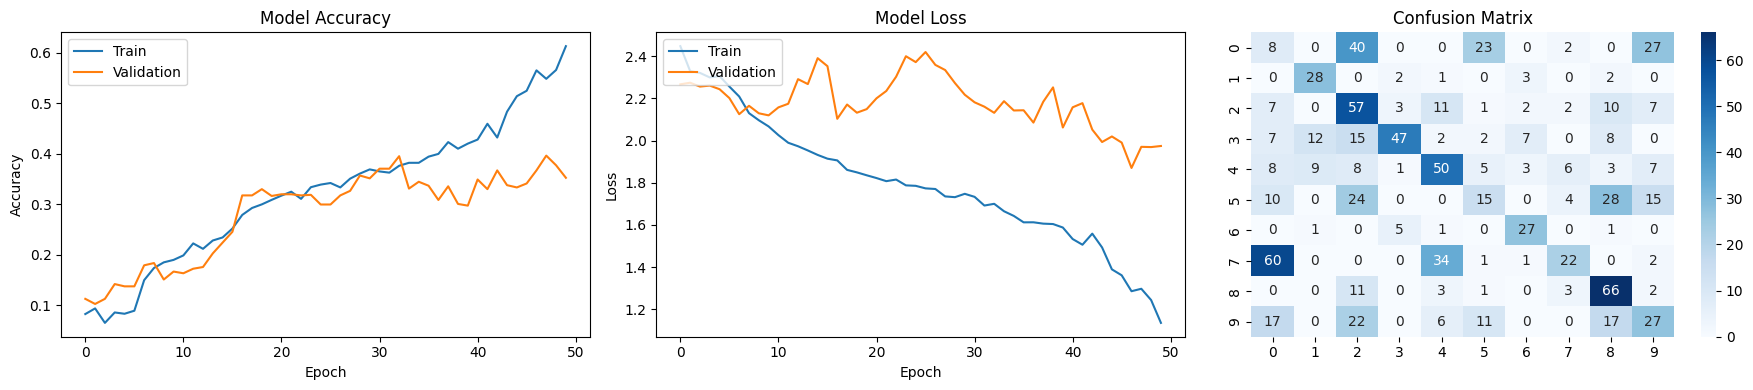

In [25]:
plot_graphs(m_metrics1)

### Apenas regularizer

c:\Users\joaob\virt_env\aprend_comp_2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.0665 - loss: 3.9213 - val_accuracy: 0.1126 - val_loss: 3.2199
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.0715 - loss: 3.1709 - val_accuracy: 0.1160 - val_loss: 2.8761
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.0848 - loss: 2.8749 - val_accuracy: 0.1126 - val_loss: 2.6975
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.0710 - loss: 2.7119 - val_accuracy: 0.1126 - val_loss: 2.5906
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.0648 - loss: 2.6170 - val_accuracy: 0.1126 - val_loss: 2.6368
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.0762 - loss: 2.6012 - val_accuracy: 0.1126 - val_loss: 2.4842
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.0869 - loss: 2.5167 - val_accuracy: 0.1126 - val_loss: 2.4444
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.1231 - loss: 2.4616 -

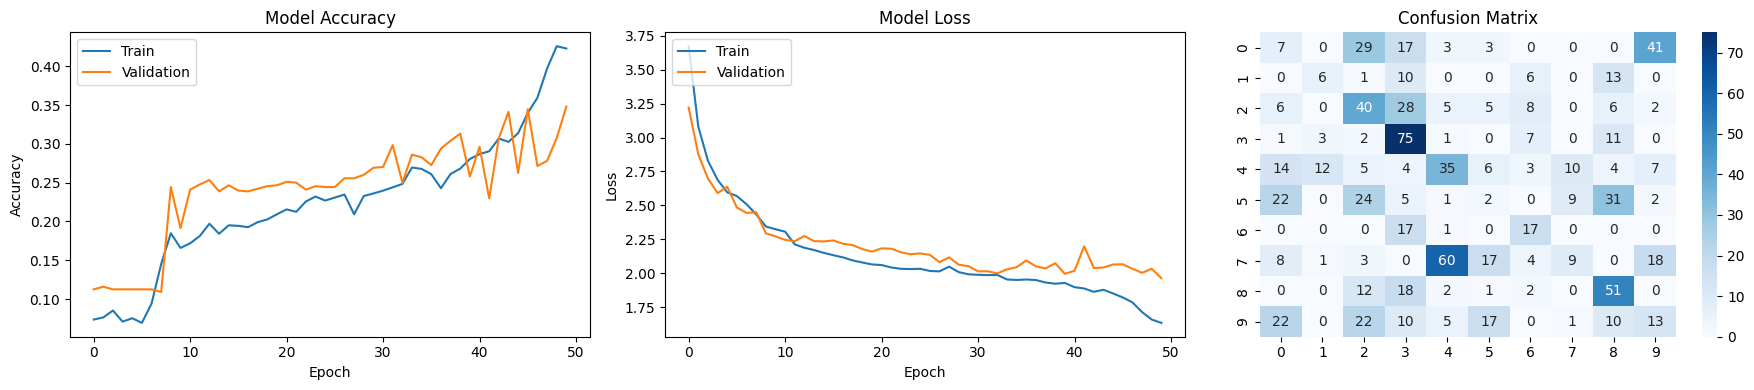

In [29]:
model = create_model2(129, 345)
# compilar o modelo com o optimizer Adam
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
# treinar o modelo
LSTM_model = model.fit(
    X_train, y_train, 
    epochs=EPOCHS,
    batch_size=32, 
    shuffle=False, 
    validation_data=(X_val, y_val)
)
# prever no set de test
y_pred = model.predict(X_test)

# avaliar o modelo
y_pred_reshape = np.argmax(y_pred, axis=1)
y_test_reshape = np.argmax(y_test, axis=1)
TestLoss, Testacc = model.evaluate(X_test, y_test)

# guardar os resultados para o guardar disco/visualizar no futuro
m_metrics2 = {
    'loss': TestLoss, 
    'accuracy': Testacc, 
    'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 
    'history': model, 
    'history_dict': LSTM_model.history
}

# eliminar o modelo para começar de novo para evitar memory leak
del model
keras.backend.clear_session()
gc.collect()

print("Done.")
plot_graphs(m_metrics2)

### Apenas dropout

c:\Users\joaob\virt_env\aprend_comp_2\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.0934 - loss: 2.7209 - val_accuracy: 0.1126 - val_loss: 2.2730
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.1001 - loss: 2.5439 - val_accuracy: 0.1025 - val_loss: 2.2855
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.0924 - loss: 2.4418 - val_accuracy: 0.1171 - val_loss: 2.2791
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.1113 - loss: 2.2824 - val_accuracy: 0.1926 - val_loss: 2.2877
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.1298 - loss: 2.2524 - val_accuracy: 0.1250 - val_loss: 2.3458
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.1585 - loss: 2.1902 - val_accuracy: 0.1926 - val_loss: 2.3109
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.1843 - loss: 2.1494 - val_accuracy: 0.1926 - val_loss: 2.2820
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.1926 - loss: 2.1067 -

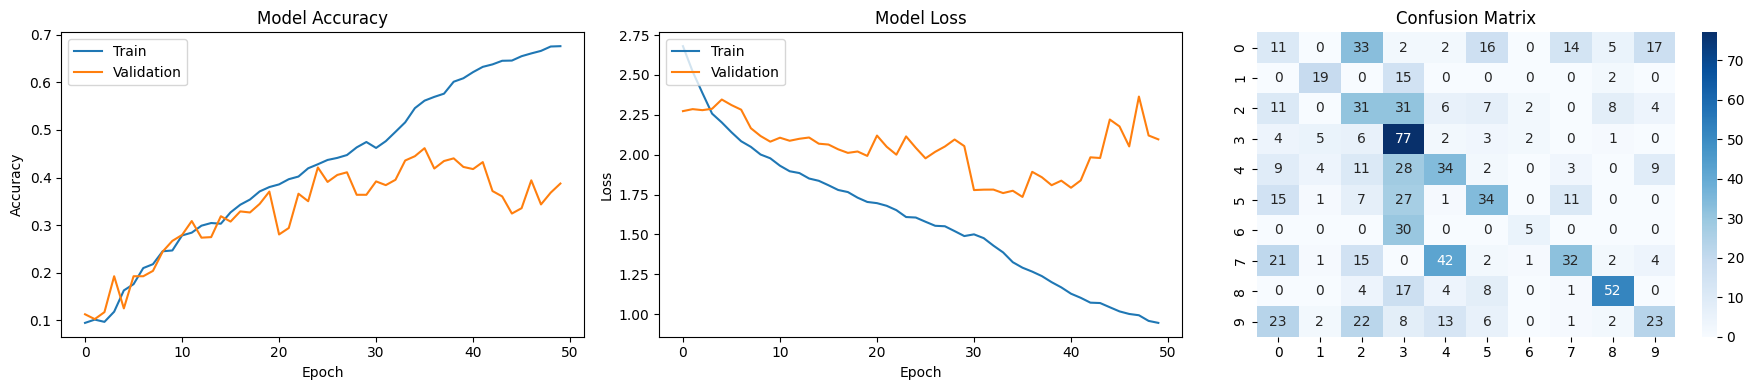

In [28]:
model = create_model3(129, 345)
# compilar o modelo com o optimizer Adam
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
# treinar o modelo
LSTM_model = model.fit(
    X_train, y_train, 
    epochs=EPOCHS,
    batch_size=32, 
    shuffle=False, 
    validation_data=(X_val, y_val)
)
# prever no set de test
y_pred = model.predict(X_test)

# avaliar o modelo
y_pred_reshape = np.argmax(y_pred, axis=1)
y_test_reshape = np.argmax(y_test, axis=1)
TestLoss, Testacc = model.evaluate(X_test, y_test)

# guardar os resultados para o guardar disco/visualizar no futuro
m_metrics3 = {
    'loss': TestLoss, 
    'accuracy': Testacc, 
    'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 
    'history': model, 
    'history_dict': LSTM_model.history
}

# eliminar o modelo para começar de novo para evitar memory leak
del model
keras.backend.clear_session()
gc.collect()

print("Done.")
plot_graphs(m_metrics3)